In [1]:
import numpy as np
from mp_api.client import MPRester
from pymatgen.core.operations import SymmOp
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.phonon.plotter import PhononBSPlotter
from jupyter_jsmol.pymatgen import quick_view
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
mp_key = "txVH20lqfEIM4Yxb2k5ptbih3BpgcIsN"
mp_id = "mp-8175"

In [3]:
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    el_bs = m.get_bandstructure_by_material_id(mp_id)
    el_dos = m.get_dos_by_material_id(mp_id)
    ph_bs = m.get_phonon_bandstructure_by_material_id(mp_id)
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)
    data = BSPlotter(el_bs).bs_plot_data()
conv_struc = SpacegroupAnalyzer(prim_struc).get_conventional_standard_structure()
symmops = SpacegroupAnalyzer(conv_struc).get_space_group_operations()

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

# Analyse bande interdite

In [4]:
band_gap = el_bs.get_band_gap()
print("Bande interdite: \n", "Energie (Eg) :",band_gap.get('energy'),"eV \n", "Bande directe ?", band_gap.get('direct'),"\n", "Transition dans la bande :",band_gap.get('transition'))

Bande interdite: 
 Energie (Eg) : 0.8820000000000001 eV 
 Bande directe ? False 
 Transition dans la bande : Z-\Gamma


$E_g$ représente la différence entre le sommet de la dernière bande de valence (VBM) et la base de la première bande de conduction (CBM). Elle détermine si le matériau est conducteur, semi-conducteur ou isolant. Au vue de la valeur donnée, on peut en conclure que le cristal agit comme un semi-conducteur au niveau électrique. 

La bande interdite n'est pas une bande directe, ce qui signifie que le VBM et le CBM ne sont pas sur les mêmes vecteurs d'ondes. Dans notre cas le vecteur d'onde évolue dans la bande interdite dans la direction $Z-\Gamma$.

## Maximum de la bande de valence (VBM)

In [5]:
vbm_data= el_bs.get_vbm()
Efermi = data.get('zero_energy')

print("Dernière bande de valence : \n", "Index des bandes contenant le VBM :", vbm_data.get('band_index'),"\n", "Energie du VBM :", vbm_data.get('energy'), "eV \n", "Sur le graphe (E-Efermi):",vbm_data.get('energy')-Efermi,"eV \n")

Dernière bande de valence : 
 Index des bandes contenant le VBM : defaultdict(<class 'list'>, {<Spin.up: 1>: [15, 16]}) 
 Energie du VBM : 2.496 eV 
 Sur le graphe (E-Efermi): 0.0 eV 



La dernière bande de valence est donc la bande 16.

## Minimum de la bande de conduction (CBM)

In [6]:
cbm_data= el_bs.get_cbm()
Efermi = data.get('zero_energy')

print("Dernière bande de valence : \n", "Index des bandes contenant le VBM :", cbm_data.get('band_index'),"\n", "Energie du CBM :", cbm_data.get('energy'), "eV \n", "Sur le graphe (E-Efermi):",cbm_data.get('energy')-Efermi,"eV \n")

Dernière bande de valence : 
 Index des bandes contenant le VBM : defaultdict(<class 'list'>, {<Spin.up: 1>: [17]}) 
 Energie du CBM : 3.378 eV 
 Sur le graphe (E-Efermi): 0.8820000000000001 eV 



La première bande de conduction est donc la bande 17. 

De plus, on remarque que la différence entre $E_{vbm}$ et $E_{cbm}$ est bien égale à $E_g$ trouvée précédemment.

# Electronic bandstructure

In [52]:
fig_el_bs = get_plot_bs(el_bs, plot_range=[-4,7])

i_vbm = list(vbm_data['band_index'].values())[-1][-1]
i_cbm=list(cbm_data['band_index'].values())[-1][0]

Evbm = vbm_data.get('energy') - Efermi
Ecbm = cbm_data.get('energy')- Efermi


In [54]:
xvals = fig_el_bs.to_dict()["data"][0]["x"]
yvals_vbm = fig_el_bs.to_dict()["data"][5]["y"] #bande 16
yvals_cbm = fig_el_bs.to_dict()["data"][6]["y"]  #bande 17

k_distances = np.linspace(xvals[0],xvals[-1],100)

#Mise en évidence de la dernière bande de valence et première bande de conduction

fig_el_bs.add_trace(go.Scatter(x=xvals, y=yvals_vbm, mode = 'lines', line = dict(color = 'green', width = 2), name = "Dernière bande de valence"))
fig_el_bs.add_trace(go.Scatter(x=xvals, y=yvals_cbm, mode = 'lines', line = dict(color = 'red', width = 2), name = "Première bande de conduction"))

# Mise en évidence de la bande interdite

fig_el_bs.add_trace(go.Scatter(
    x=k_distances, y=[Ecbm] * 100,   mode="lines", line=dict(color='rgba(0,0,255,0)', width=1),showlegend=False))
  
fig_el_bs.add_trace(go.Scatter(x = k_distances, y=[Evbm]*100,fill = 'tonexty',fillcolor='rgba(0,0,255,0.4)', line = dict(color='rgba(0,0,255,0)'),name = 'Bande interdite' ))
fig_el_bs.add_trace(go.Scatter(x=k_distances, y=[Ecbm] * 100, fill = 'tonexty',fillcolor = 'rgba(0,0,255,0.4)', line=dict(color='rgba(0,0,255,0)'),showlegend=False))

#Mise en évidence du CBM et VBM

xvals_band_edges = []
yvals_band_edges = []
for i in el_bs.get_vbm()["kpoint_index"]:
    xvals_band_edges.append(xvals[i])
    yvals_band_edges.append(yvals_vbm[i])
for i in el_bs.get_cbm()["kpoint_index"]:
    xvals_band_edges.append(xvals[i])
    yvals_band_edges.append(yvals_cbm[i])
    
for i in el_bs.get_vbm()["kpoint_index"]:
    scatter = go.Scatter(
        x = xvals_band_edges, y = yvals_band_edges,
        mode = "markers", marker = dict(color="black"),
        showlegend=False)
    fig_el_bs.add_trace(scatter)
    
#Affichage du graphe

fig_el_bs.update_layout(xaxis_range = [xvals[0], xvals[-1]])
fig_el_bs.show() 


Le graphique ci-dessus représente la structure des bandes électroniques du $KTlO_2$ et met en évidence toutes les données extraites ci-dessus. La dernière bande de valence et la première bande de conduction sont représentées respectiment en vert et en rouge. Les points mis en évidence en noir sont le VBM et le CBM, ils délimitent la bande interdite et on remarque bien le passage du vecteur d'onde $Z$ à $\Gamma$ dans cette bande.

# Dispertion de la première bande de conduction et dernière bande de valence

In [84]:
#calcul des pentes pour les bandes de valence et de conduction
import matplotlib.pyplot as plt

distance = data.get('ticks').get('distance') 
vbms = data.get('vbm')
cbms = data.get('cbm')


def calculate_slopes(x,y):
    slopes=[]
    for i in range (1,len(x)):
        dx = x[i]-x[i-1]
        if dx == 0:
            continue
        dy=y[i]-y[i-1]
        
        slope = dy/dx
        slopes.append([slope,x[i-1],y[i-1],dx,dy])
     
    return np.array(slopes)

    
slopes_vbm = calculate_slopes(distance, yvals_vbm)
slopes_cbm = calculate_slopes(distance, yvals_cbm)


M_disp_vbm =np.argmax(slopes_vbm[:,0])
m_disp_vbm =np.argmin(slopes_vbm[:,0])

M_disp_cbm = np.argmax(slopes_cbm[:,0])
m_disp_cbm =np.argmin(slopes_cbm[:,0])

Text(0.05, 0.9820000000000001, '-')

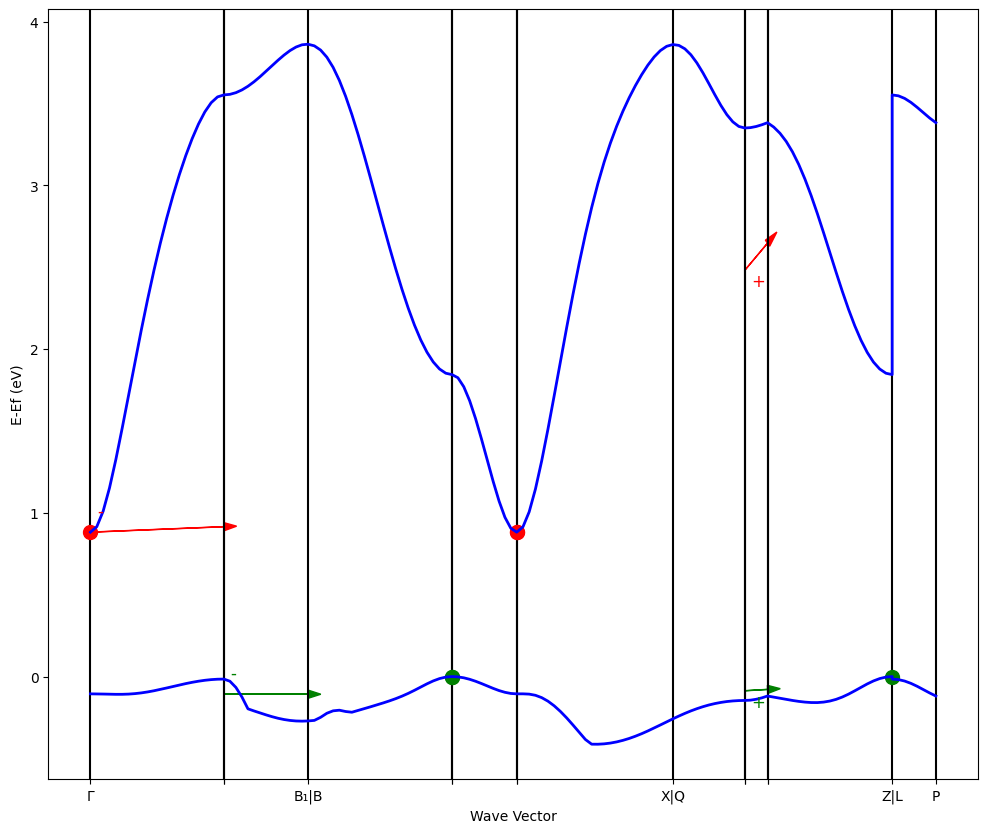

In [85]:
#Affichage du graphe avec les flèches

fig, ax = plt.subplots(figsize=(12,10))

#ajout des lignes verticales noires
for i in range(len(distance)):
    plt.axvline(distance[i],0,color="black")
    

#ajout des markeur sur les VBM et CBM    
for i in range(len(vbms)):
    (a,b) = vbms[i]
    plt.plot(a,b,'og',markersize=10)
for i in range(len(cbms)):
    (a,b) = cbms[i]
    plt.plot(a,b,'or',markersize=10)
    
#Ajout de la légende des vecteurs d'onde
    
ax.set_xticks(distance)
ax.set_xticklabels(['\u0393','L',"",'B\u2081|B', 'Z',"",'\u0393',"",'X|Q','F',"",'P\u2081',"",'Z|L','P'])
ax.set_xlabel('Wave Vector')
ax.set_ylabel('E-Ef (eV)')


ax.plot(xvals, yvals_vbm, label = 'Dernière bande de valence', color = 'blue', lw=2)
ax.plot(xvals, yvals_cbm, label = 'Première bande de conduction', color = 'blue', lw=2)

ax.arrow(slopes_vbm[M_disp_vbm, 1], slopes_vbm[M_disp_vbm, 2],
         slopes_vbm[M_disp_vbm, 3], slopes_vbm[M_disp_vbm, 4],
         head_width=0.05, head_length=0.1, fc='green', ec='green')

ax.arrow(slopes_vbm[m_disp_vbm, 1], slopes_vbm[m_disp_vbm, 2],
         slopes_vbm[m_disp_vbm, 3], slopes_vbm[m_disp_vbm, 4],
         head_width=0.05, head_length=0.1, fc='green', ec='green')

ax.arrow(slopes_cbm[M_disp_cbm, 1], slopes_cbm[M_disp_cbm, 2],
         slopes_cbm[M_disp_cbm, 3], slopes_cbm[M_disp_cbm, 4],
         head_width=0.05, head_length=0.1, fc='red', ec='red')
ax.arrow(slopes_cbm[m_disp_cbm, 1], slopes_cbm[m_disp_cbm, 2],
         slopes_cbm[m_disp_cbm, 3], slopes_cbm[m_disp_cbm, 4],
         head_width=0.05, head_length=0.1, fc='red', ec='red')

ax.text(slopes_vbm[M_disp_vbm, 1] + 0.05, slopes_vbm[M_disp_vbm, 2] - 0.1, "+", fontsize=12, color='green')
ax.text(slopes_vbm[m_disp_vbm, 1] + 0.05, slopes_vbm[m_disp_vbm, 2] + 0.1, "-", fontsize=12, color='green')

ax.text(slopes_cbm[M_disp_cbm, 1] + 0.05, slopes_cbm[M_disp_cbm, 2] - 0.1, "+", fontsize=12, color='red')
ax.text(slopes_cbm[m_disp_cbm, 1] + 0.05, slopes_cbm[m_disp_cbm, 2] + 0.1, "-", fontsize=12, color='red')

Mon graphique ne semble pas correct, je voulais mesurer les pentes entre les points d'intersections des deux bandes avec les axes verticaux. J'aurais ainsi pu déterminer les directions de la plus haute et plus basse dispertion pour la dernière bande de valence et la première de conduction.


Néanmoins comme la courbure de la dernière bande de valence est assez faible, on peut en conclure qu'il y aura une faible dispertion. De même, la courbure de la première bande de conduction étant élevée on peut conclure qu'il y aura une haute dispertion. 

# Masse effective au CBM et au VBM

In [139]:
vbm_index = np.argmax(yvals_vbm)  # Trouve l'index du maximum de yvals_vbm
cbm_index = np.argmin(yvals_cbm) 
hbar2 = (1.0545718e-34)**2
eV_to_Joule = 1.602176634e-19

## Au sommet de la dernière bande de valence

/tmp/ipykernel_1896282/3979389519.py:25: RankWarning:

Polyfit may be poorly conditioned



Parabole d'approximation :  y(k) = 0.011568587277313632k² + -5.780694828583902e-05k + -0.09317631954555294 
 Dérivée seconde :  0.023137174554627264 eVÅ² 
 Masse effective :  3.000071400116173e-28 kg




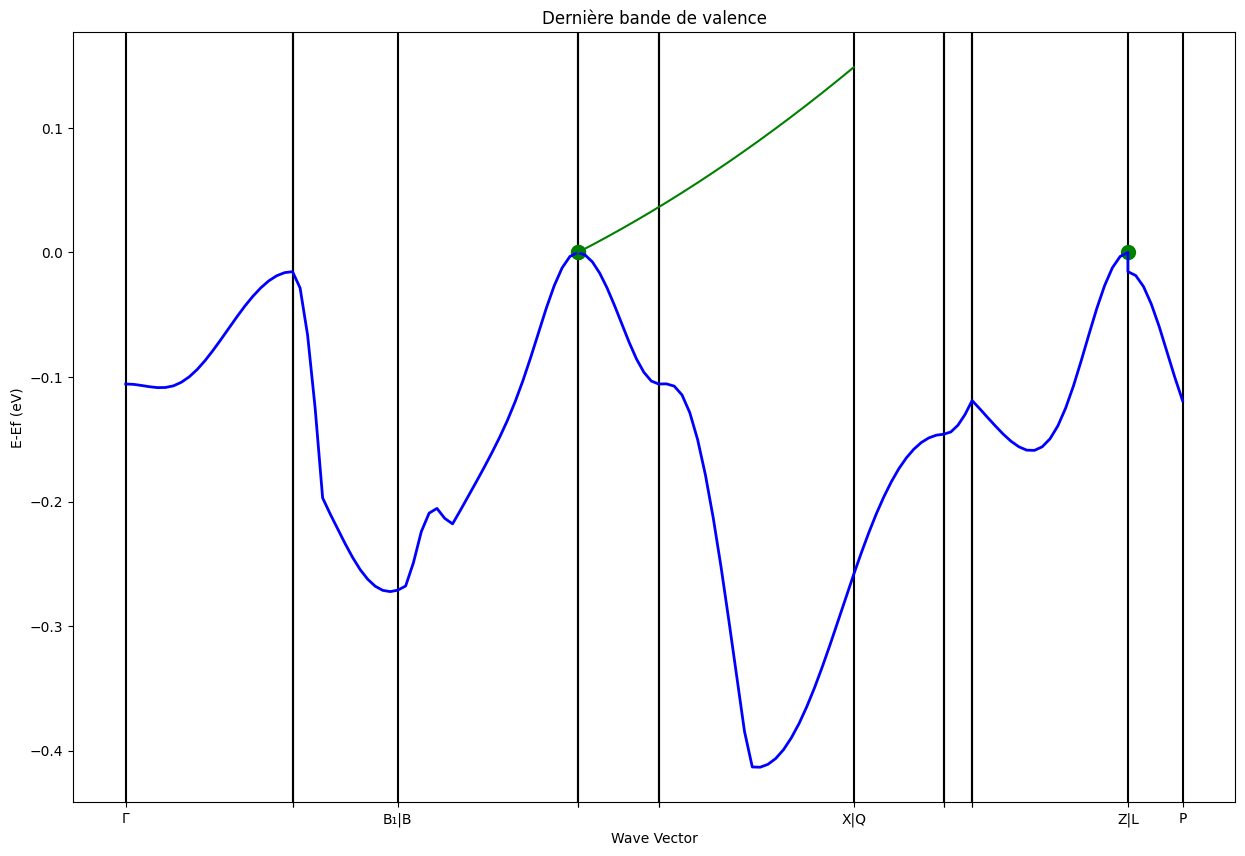

In [131]:
# affichage dernière bande de valence et des VBM 

fig,ax = plt.subplots(1,1,figsize=[15,10])
for i in range(len(distance)):
	plt.axvline(distance[i],0,color="black")
for i in range(len(vbms)):
	(a,b) = vbms[i]
	plt.plot(a,b,'og',markersize=10)
ax.plot(xvals, yvals_vbm, label = 'Dernière bande de valence', color = 'blue', lw=2)

ax.set_xticks(distance)
ax.set_xticklabels(['\u0393','L',"",'B\u2081|B','Z',"",'\u0393',"",'X|Q','F',"",'P\u2081',"",'Z|L','P'])
ax.set_xlabel('Wave Vector')
ax.set_ylabel('E-Ef (eV)')
plt.title('Dernière bande de valence')

#calcul de la parabole aux alentours du VBM
ks = np.zeros(3)
es = np.zeros(3)

(ks[1], es[1]) = (xvals[vbm_index], yvals_vbm[vbm_index])  # Point du VBM
(ks[0], es[0]) = (xvals[vbm_index - 1], yvals_vbm[vbm_index - 1])  # Point à gauche
(ks[2], es[2]) = (xvals[vbm_index + 1], yvals_vbm[vbm_index + 1])  # Point à droite
a = np.polyfit(ks,es,2)

print("Parabole d'approximation : ","y(k) = "+str(a[0])+ "k\u00b2 + "+str(a[1])+"k + "+str(a[2]),
"\n Dérivée seconde : ",str(2*a[0])+" eV\u212b\u00b2","\n Masse effective : ",str(hbar2/(2*a[0]*eV_to_Joule*(10**-10)**2))+" kg",)
print("\n")


plt.plot(x,np.polyval(a,x),'g')
plt.show()

Nous avons une formule de parabole telle que $a*k^2 + b*k +c$, et donc la dérivée seconde $\frac{\delta^2 E}{\delta k \delta k} = 2*a$. 

Dans notre cas nous aurons donc que $\frac{\delta^2 E}{\delta k_i \delta k_j} = 0.023137174554627264 [eVÅ²]$

Sachant que 1 eV = $1.602176634e-19$ Joules et que 1 Å = $10^{-10} m$, notre dérivée seconde devient alors : 

$0.023137174554627264 * 1.602176634e-19 * 10^{-20} = 3.706983956e-41$ $[Jm^2]$

La masse effective étant donnée par la relation suivante : $ m*_{ij} = \frac{\hbar^2}{\frac{\delta^2 E}{\delta k_i \delta k_j}}= \frac{(1.0545718e-34)^2}{(3.706983956e-41)} = 3.000071400116173e-28 [kg]$

Comme nous avons conclu à une basse dispertion dans le cas de la dernière bande de valence, cela fait sens d'avoir une masse effective relativement élevée(en valeur absolue). COmme celle-ci représente la résistance aux mouvements des porteurs de charges on peut en déduire que les trous ont une faible mobilité.

Mon graphique ne représente pas ce que je pensais que le code ferait et je ne comprends pas l'erreur.

Parabole d'approximation :  y(k) = -0.044359595200374996k² +0.6712155566194842k +0.8819999999999997 
 Dérivée seconde :  -0.08871919040074999 eVÅ² 
 Masse effective :  -7.823918968070984e-29 kg




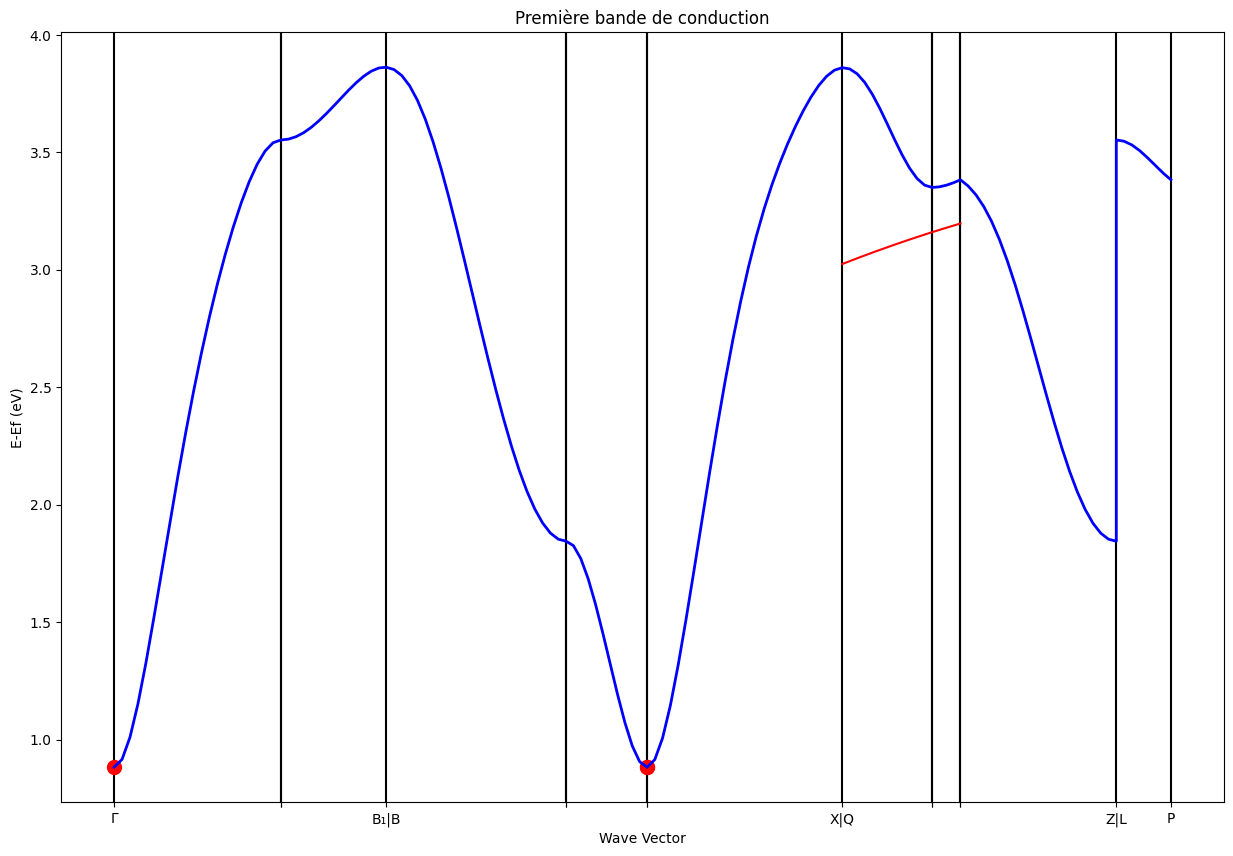

In [141]:
#Affichage première bande de conduction et du CBM

fig,ax = plt.subplots(1,1,figsize=[15,10])
for i in range(len(distance)):
	plt.axvline(distance[i],0,color="black")
for i in range(len(cbms)):
	(a,b) = cbms[i]
	plt.plot(a,b,'or',markersize=10)
ax.plot(xvals, yvals_cbm, label = 'Première bande de conduction', color = 'blue', lw=2)
ax.set_xticks(distance)
ax.set_xticklabels(['\u0393','L',"",'B\u2081|B','Z',"",'\u0393',"",'X|Q','F',"",'P\u2081',"",'Z|L','P'])
ax.set_xlabel('Wave Vector')
ax.set_ylabel('E-Ef (eV)')
plt.title('Première bande de conduction')

#calcul de la parabole d'approximation aux alentours du VBM
ks2 = np.zeros(3)
es2 = np.zeros(3)
(ks2[1],es2[1]) = (xvals[cbm_index],yvals_cbm[cbm_index])
(ks2[0],es2[0]) = (xvals[cbm_index-1],yvals_cbm[cbm_index-1])
(ks2[2],es2[2]) = (xvals[cbm_index+1],yvals_cbm[cbm_index+1])
a2 = np.polyfit(ks2,es2,2)

#affichage des résultats
print("Parabole d'approximation : ","y(k) = "+str(a2[0])+"k\u00b2 +"+str(a2[1])+"k +" +str(a2[2]), "\n Dérivée seconde : ",str(2*a2[0])+" eV\u212b\u00b2", "\n Masse effective : ",str(hbar2/(2*a2[0]*eV_to_Joule*(10**-10)**2))+" kg",)
print("\n")

plt.plot(x2,np.polyval(a2,x2),'r')
plt.show()

Nous avons une formule de parabole telle que $a*k^2 + b*k +c$, et donc la dérivée seconde $\frac{\delta^2 E}{\delta k \delta k} = 2*a$. 

Dans notre cas nous aurons donc que $\frac{\delta^2 E}{\delta k_i \delta k_j} = -0.08871919040074999 [eVÅ²]$

Sachant que 1 eV = $1.602176634e-19$ Joules et que 1 Å = $10^{-10} m$, notre dérivée seconde devient alors : 

$-0.08871919040074999 * 1.602176634e-19 * 10^{-20} = -1.421438138e-40$ $[Jm^2]$

La masse effective étant donnée par la relation suivante : $ m*_{ij} = \frac{\hbar^2}{\frac{\delta^2 E}{\delta k_i \delta k_j}}= \frac{(1.0545718e-34)^2}{-1.421438138e-4} = -7.823918968070984e-29 [kg]$

Comme nous avons conclu à une haute dispertion dans le cas de la première bande de conduction cela fait sens d'avoir une masse effective relativement faible(en valeur absolue). COmme celle-ci représente la résistance aux mouvements des porteurs de charges on peut en déduire que les électrons y sont très mobiles.

Mon graphique ne représente pas ce que je pensais que le code ferait et je ne comprends pas l'erreur.